In [1]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import networkx as nx

import folium
import branca.colormap as cmap
import json
from IPython.display import display, HTML

In [2]:
import agent as ag

place = "Eindhoven, Netherlands"

data, _ = ag.dists.initialize()

geodata = data["geodata"]
graph = data["graph"]

# Create a Folium map centered on Eindhoven
eindhoven_map = folium.Map(
    location=[51.4416, 5.4697],  # Coordinates for Eindhoven
    zoom_start=12,
    tiles="OpenStreetMap",
)
# Create a Folium feature group for the geodata
folium.FeatureGroup(name="Eindhoven Boundaries").add_to(eindhoven_map)
# Add the geodata to the map
folium.GeoJson(
    geodata,
    name="Eindhoven Boundaries",
    style_function=lambda feature: {
        "fillColor": "blue",
        "color": "black",
        "weight": 1,
        "fillOpacity": 0.5,
    },
).add_to(eindhoven_map)

display(HTML(eindhoven_map._repr_html_()))

Initializing data...
Loading geodata from geodata.pickle...
Loading graph from graph.pickle...
Loading features from features.pickle...


c:\Users\euseb\AppData\Local\Programs\Python\Python313\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\Users\euseb\OneDrive - TU Eindhoven\Documents\GitHub\Project-4CBLW00-17\ImprovedSimulation\eindhovenDists3.py:219: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  features["centroid"] = features.geometry.centroid
c:\Users\euseb\AppData\Local\Programs\Python\Python313\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

Loading all pairs distances from all_pairs_distances.feather...


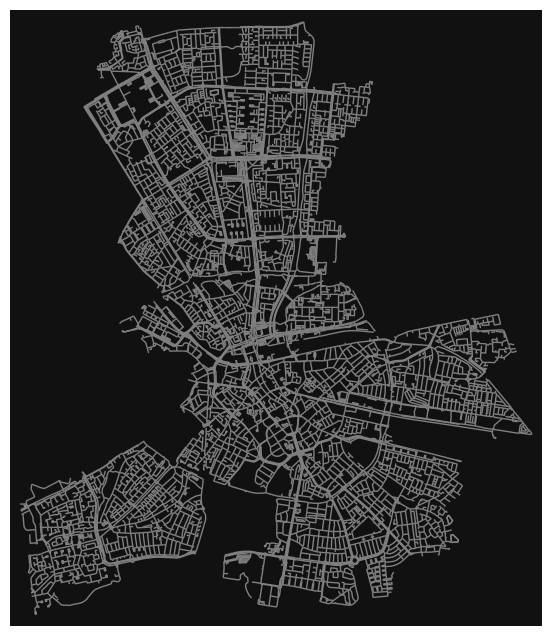

In [3]:
# Plot the graph on the map
fig, ax = ox.plot_graph(graph, show=False, close=False, node_size=0, edge_color="gray", edge_linewidth=1)


Residence coordinates: (51.42639112749659, 5.463520111520844)
Workplace coordinates: (51.4480482, 5.4552432)


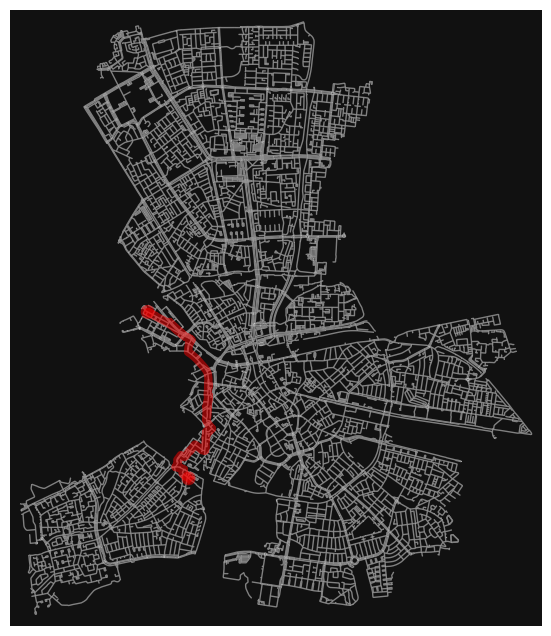

In [4]:
import agent as ag

residences = gpd.GeoDataFrame(data["residences"])
workplaces = gpd.GeoDataFrame(data["workplaces"])

residences = data["residences"]
workplaces = data["workplaces"] 

import matplotlib as plt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

residence = residences.sample(1).iloc[0]
workplace = workplaces.sample(1).iloc[0]

# Get coordinates for residence and workplace
residence_coords = (residence.geometry.centroid.y, residence.geometry.centroid.x)
workplace_coords = (workplace.geometry.centroid.y, workplace.geometry.centroid.x)

print(f"Residence coordinates: {residence_coords}")
print(f"Workplace coordinates: {workplace_coords}")

# Plot route from residence to workplace
route = ox.shortest_path(graph, residence["nearest_node"], workplace["nearest_node"])

fig, ax = ox.plot_graph_route(
    graph,
    route,
    route_linewidth=6,
    node_size=0.1,
    edge_color="gray",
    show=False,
    close=False,
)

In [5]:
# Display the agent's route on the map
route = nx.shortest_path(graph, residence['nearest_node'], workplace['nearest_node'], weight='length')  # type: ignore
folium.PolyLine(
    locations=[(graph.nodes[n]['y'], graph.nodes[n]['x']) for n in route],
    color='blue',
    weight=5,
    opacity=0.7,
).add_to(eindhoven_map)
# Display the Folium map with the agent's route
display(HTML(eindhoven_map._repr_html_()))

In [6]:
import random
seed = 42

universities = data["universities"]
offices = data["offices"]

# Function to create random Person objects
def create_person(residence_coords, type = 'child',  seed=42, walk_only=False, smart=False):

    random.seed(seed)
    print("getting residence amenity...")
    
    residence = ag.dists.get_nearest_amenities(
        graph, residence_coords, ('apartments', 'house'), 1
    )
    print(f"Selected residence: {residence}")

    match type:
        case 'child':
            walk_speed = random.uniform(3, 5)
            bike_speed = random.uniform(6, 12)
            bike_freq = random.uniform(0.0, 0.8) if not walk_only else 0.0
            work_freq = 0.0
            features_freqs = {
                # According to statistics there are about 19k schoolchildren in eindhoven and 33k in ages 1-15
                # We can approximate the half of the rest going to kindergarten (even if it's not 100% accurate)
                ('school',) if random.random() < 0.8 else ('kindergarten',): 1.0,
                ('park', 'playground'): random.uniform(0.2, 0.9),
                ('pharmacy', 'hospital', 'clinic', 'doctors'): random.uniform(0.05, 0.2),
            }
            return ag.agent(
                    residence = residence,
                    work = None,
                    walk_speed=walk_speed,
                    bike_speed=bike_speed,
                    bike_freq=bike_freq,
                    work_freq=0.0,
                    features_freqs=features_freqs,
                    seed=seed,
                    curiosity=random.uniform(0.5, 1.0),
                    smart=smart
                )
        case 'student':
            work = universities.sample(1)
            print(f"Selected university: {work}")
            walk_speed = random.uniform(3, 5)
            bike_speed = random.uniform(8, 20)
            bike_freq = random.uniform(0.0, 1.0) if not walk_only else 0.0
            work_freq = random.uniform(0.1, 0.9)
            features_freqs = {
                ('cafe', 'restaurant', 'bar', 'cinema', 'theatre'): random.uniform(0.2, 0.9),
                ('community_centre', 'library', 'bicycle_rental'): random.uniform(0.0, 0.3),
                ('park', 'fitness_centre', 'sports_centre', 'dog_park', 'pitch', 'swimming_pool'): random.uniform(0.1, 0.9),
                ('pharmacy', 'hospital', 'clinic', 'doctors'): random.uniform(0.0, 0.5),
                ('place_of_worship',): random.uniform(0.0, 0.5),
                ('supermarket', 'convenience', 'greengrocer', 'general'): random.uniform(0.2, 0.7),
                ('butcher', 'bakery', 'department_store', 'cosmetics', 'stationery'): random.uniform(0.0, 0.5)
            }
            curiosity = random.uniform(0.5, 1.0)
            return ag.agent(
                    residence=residence,
                    work=work,
                    walk_speed=walk_speed,
                    bike_speed=bike_speed,
                    bike_freq=bike_freq,
                    work_freq=work_freq,
                    features_freqs=features_freqs,
                    curiosity=curiosity,
                    seed=seed,
                    smart=smart
                )
        case 'adult':
            work = offices.sample(1)
            print(f"Selected office: {work}")
            walk_speed = random.uniform(3, 5)
            bike_speed = random.uniform(8, 20)
            bike_freq = random.uniform(0.0, 1.0) if not walk_only else 0.0
            work_freq = random.uniform(0.8, 1.0)
            features_freqs = {
                ('cafe', 'restaurant', 'bar', 'cinema', 'theatre'): random.uniform(0.1, 0.7),
                ('community_centre', 'library', 'bicycle_rental'): random.uniform(0.0, 0.3),
                ('park', 'fitness_centre', 'sports_centre', 'dog_park', 'pitch', 'swimming_pool'): random.uniform(0.1, 0.9),
                ('pharmacy', 'hospital', 'clinic', 'doctors'): random.uniform(0.05, 0.2),
                ('place_of_worship',): random.uniform(0.0, 0.5),
                ('supermarket', 'convenience', 'greengrocer', 'general'): random.uniform(0.2, 0.7),
                ('butcher', 'bakery', 'department_store', 'cosmetics', 'stationery'): random.uniform(0.0, 0.5) 
                }
            curiosity = random.uniform(0.5, 1.0)
            return ag.agent(
                    residence=residence,
                    work=work,
                    walk_speed=walk_speed,
                    bike_speed=bike_speed,
                    bike_freq=bike_freq,
                    work_freq=work_freq,
                    features_freqs=features_freqs,
                    curiosity=curiosity,
                    seed=seed,
                    smart=smart
                )
        case 'senior':
            walk_speed = random.uniform(3, 5)
            bike_speed = random.uniform(8, 12)
            bike_freq = random.uniform(0.0, 1.0) if not walk_only else 0.0
            work_freq = 0.0
            features_freqs = {
                ('cafe', 'restaurant', 'bar', 'cinema', 'theatre'): random.uniform(0.25, 0.75),
                ('community_centre', 'library', 'bicycle_rental'): random.uniform(0.0, 0.75),
                ('park', 'fitness_centre', 'sports_centre', 'dog_park', 'pitch', 'swimming_pool'): random.uniform(0.1, 0.5),
                ('pharmacy', 'hospital', 'clinic', 'doctors'): random.uniform(0.1, 0.5),
                ('place_of_worship',): random.uniform(0.0, 0.5),
                ('supermarket', 'convenience', 'greengrocer', 'general'): random.uniform(0.2, 0.7),
                ('butcher', 'bakery', 'department_store', 'cosmetics', 'stationery'): random.uniform(0.0, 0.5)
            }
            curiosity = random.uniform(0.5, 1.0)
            return ag.agent(
                    residence=residence,
                    work=None,
                    walk_speed=walk_speed,
                    bike_speed=bike_speed,
                    bike_freq=bike_freq,
                    work_freq=work_freq,
                    features_freqs=features_freqs,
                    curiosity=curiosity,
                    seed=seed,
                    smart=smart
                )

In [7]:
# Create a list of agents
persons = []
# Create a list of Person objects with different types
for i in range(10):  # Create 10 random persons
    print(f"Creating person {i+1}")
    residence = residences.sample(1).iloc[0]
    residence_cds = (residence.geometry.centroid.y, residence.geometry.centroid.x)
    person_type = random.choice(['child', 'student', 'adult', 'senior'])
    person = create_person(residence_cds, type=person_type, seed=seed, smart=False)
    persons.append(person)


Creating person 1
getting residence amenity...
Getting nearest amenities from location
Getting cached amenity node
Getting nearest amenities from node
Number of amenities of type ('apartments', 'house') : 49803
Created BallTree for tags: ('apartments', 'house')
Selected residence:                                                 geometry addr:city  \
15785  POLYGON ((5.5324 51.43292, 5.53237 51.43294, 5...       NaN   

      addr:housenumber addr:postcode addr:street brand brand:wikidata  \
15785              NaN           NaN         NaN   NaN            NaN   

      brand:wikipedia name opening_hours  ... emergency ref:rce hoops sport_1  \
15785             NaN  NaN           NaN  ...       NaN     NaN   NaN     NaN   

      boules area main_tag                  centroid nearest_node    distance  
15785    NaN  NaN    house  POINT (5.53246 51.43298)   4426921234  135.898579  

[1 rows x 214 columns]
Loading graph...
Data already loaded.
Graph loaded.
Creating person 2
getting resid

In [8]:
# Simulate the agent's daily routine
for day in range(1, 8):  # Simulate for 7 days
    for person in persons:
        print(f"Day {day}:")
        person.simulate_day()
# Display the travel data for each agent
for person in persons:
    print(f"Agent {person.residence['nearest_node']} travel data:")
    print(person.df_travel)
    print(f"Total travel time for agent {person.residence['nearest_node']}: {person.df_days['total_travel_time'].sum()} minutes")
    print(f"Work travel time for agent {person.residence['nearest_node']}: {person.df_days['work_travel_time'].sum()} minutes")
    print(f"Amenities visited by agent {person.residence['nearest_node']}: {person.df_days['amenities_visited'].tolist()}")

Day 1:
Simulating a day...
No end location provided, ending at residence.
Agent is walking today.
Sampled amenities for the day: [('school',)]
Visiting ('school',) from current location: 4426921234
Number of amenities of type ('school',) : 72
Created BallTree for tags: ('school',)
Visiting ('school',): 1301.5106934872256 meters
Travel time to ('school',): 18.250365393553523 minutes
Total travel time for the day: 18.250365393553523 minutes
Day 1:
Simulating a day...
No end location provided, ending at residence.
Agent is walking today.
Sampled amenities for the day: [('park', 'playground')]
Visiting ('park', 'playground') from current location: 4426921234
Number of amenities of type ('park', 'playground') : 251
Created BallTree for tags: ('park', 'playground')
Visiting ('park', 'playground'): 1009.0347064806238 meters
Travel time to ('park', 'playground'): 14.149136215475252 minutes
Total travel time for the day: 14.149136215475252 minutes
Day 1:
Simulating a day...
No end location prov

KeyError: 'amenities_visited'

In [ ]:
# Data based on Allecijfers.nl
# Eindhoven has about 233k inhabitants
children_nr = 33
students_nr = 34
adults_nr = 137
seniors_nr = 39
total_population = children_nr + students_nr + adults_nr + seniors_nr
children_rate = children_nr / total_population
students_rate = students_nr / total_population
adults_rate = adults_nr / total_population
seniors_rate = seniors_nr / total_population